In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import os
import sys

import numpy as np
import tensorflow as tf
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
import skimage.io
%matplotlib inline

print('sys_version', sys.version.replace('\n', ''))
print('virtual_env', os.environ.get('VIRTUAL_ENV', 'None'))
print('pwd', os.getcwd())
print('np ', np.__version__)
print('tf ', tf.__version__)

# fix import src problem
sys.path.append('..')
sns.set_style("whitegrid", {'axes.grid' : False})

sys_version 3.5.2 (default, Nov 17 2016, 17:05:23) [GCC 5.4.0 20160609]
virtual_env /home/marko/.virtualenvs/mozgalo
pwd /home/marko/Projects/mozgalo2017/notebooks
np  1.12.1
tf  1.1.0


# Mozgalo

## Datasets

In [10]:
from src.modules.dataset import *
from src.modules.dataset_utils import *


# print datasets and paths
for name, path in dataset_imgs_root.items():
    print('Dataset %s\n\texists?: %s\n' % (name, os.path.exists(path)))

Dataset cifar10
	exists?: True

Dataset stl10
	exists?: True

Dataset mozgalo
	exists?: True

Dataset cats_dogs
	exists?: True



## Dataset examples


Dataset: cifar10, n_samples: 50000, n_classes: 10


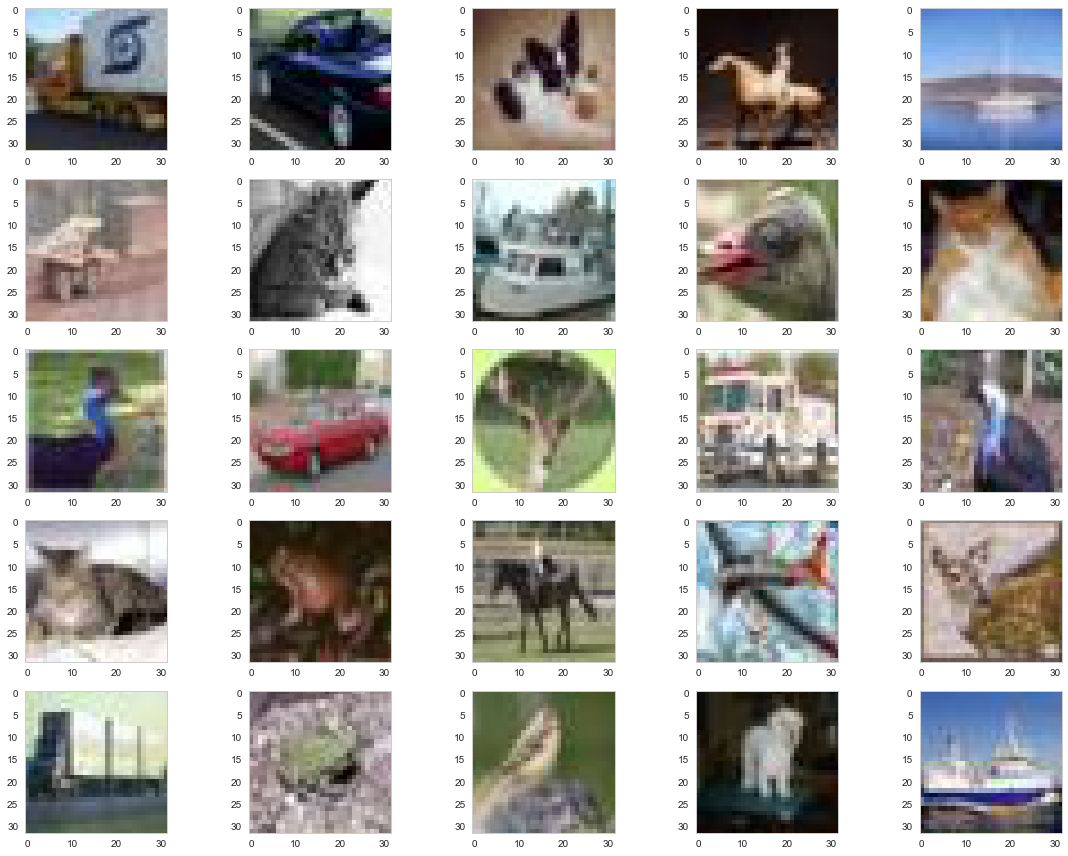


Dataset: stl10, n_samples: 5000, n_classes: 10


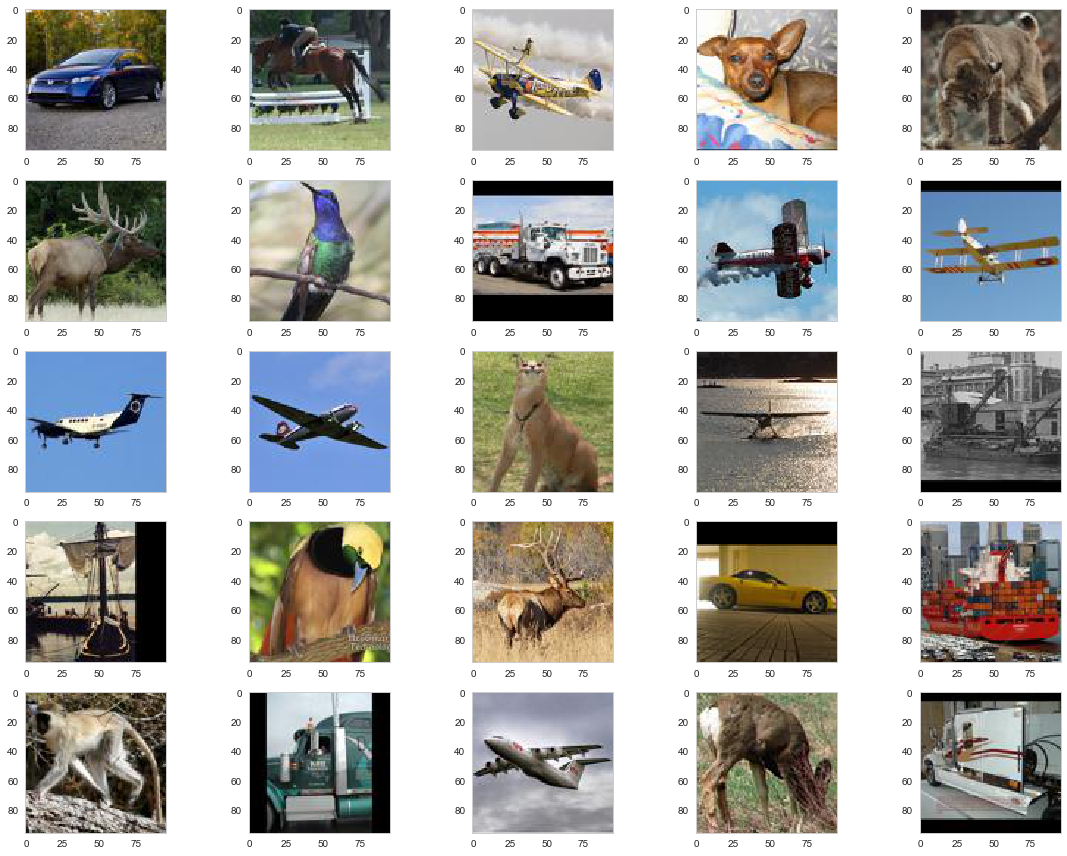


Dataset: mozgalo, n_samples: 6889, n_classes: unknown


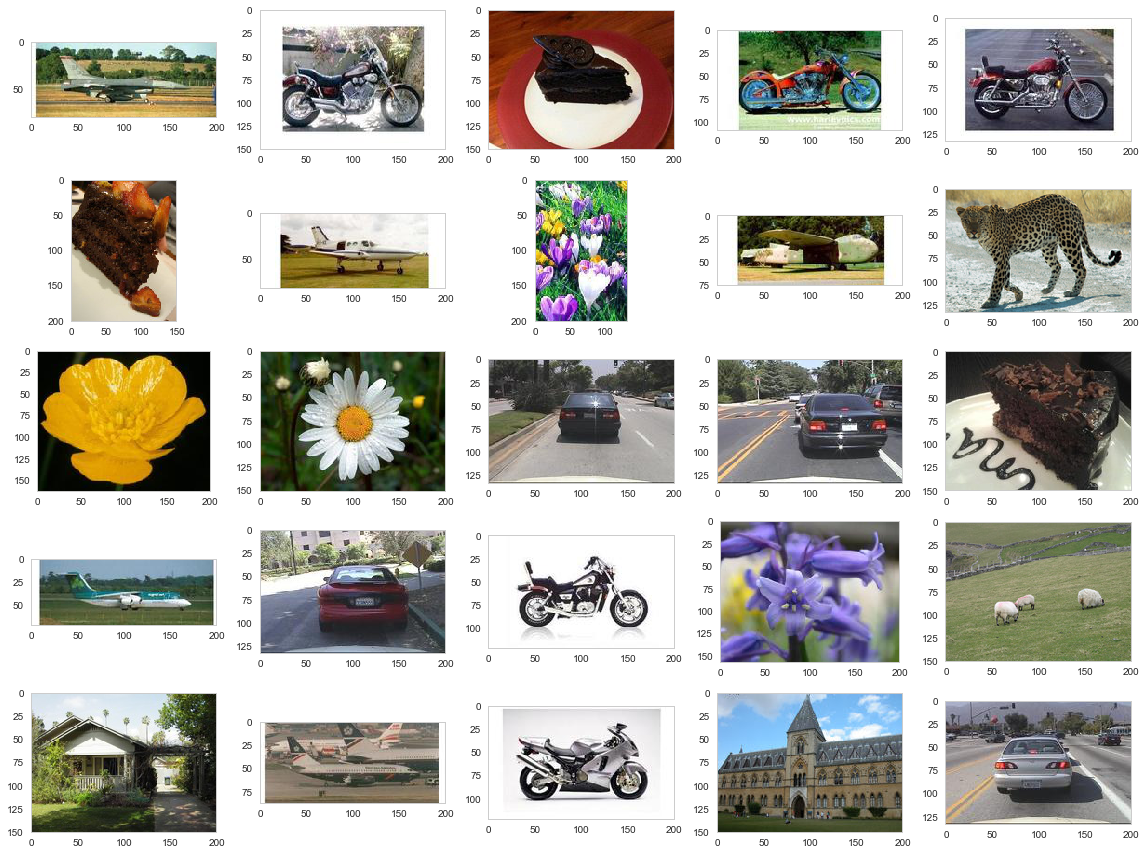


Dataset: cats_dogs, n_samples: 25000, n_classes: 2


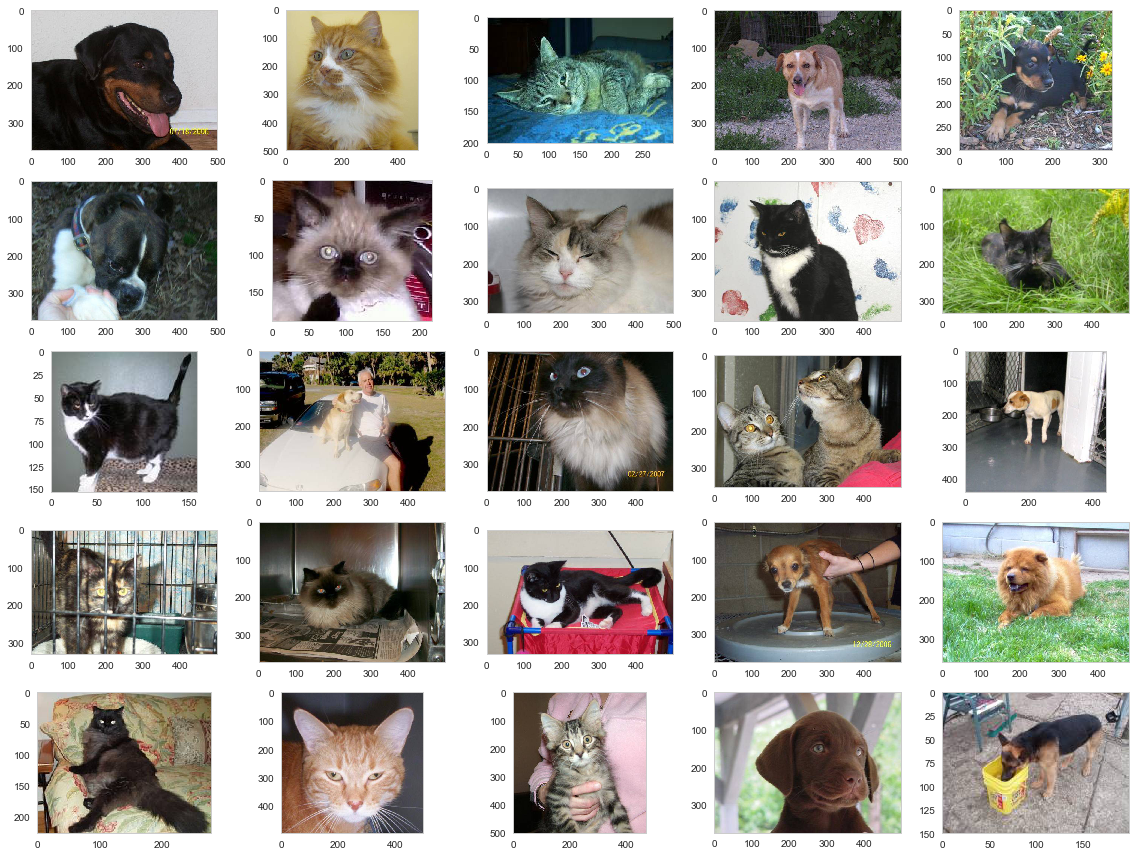

In [11]:
for name, path in dataset_imgs_root.items():
    n_samples = len(os.listdir(path))
    different_classes = get_n_different_classes(name)
    
    print()    
    print("Dataset: %s, n_samples: %s, n_classes: %s" % (name, n_samples, different_classes))
    show_random_sample(path)

## Loading dataset

In [12]:
from src.modules.feature_extractors import inceptionv3, inceptionv4, resnet50
from src.modules.utils import *
from src.modules.dataset import *

init_logging()


# Loading dataset
dataset_name = 'mozgalo'
dataset = ImageDataset(dataset_imgs_root[dataset_name])
#dataset.load_imgs()

Using TensorFlow backend.


## Feature extraction

In [13]:
# Define network used to extract features
features_extraction_model = inceptionv3.InceptionNet()
features_extraction_model.create_graph()

### Extracting features and dumping to file

- slow operation, recomended to run once and store results

Code snipet how to extract and store features
```python
dataset.extract_features(features_extraction_model)
features_path = pickled_features_path(dataset_name, features_extraction_model)
dataset.store_features(features_path)
```

### Load preextracted features from last run

In [25]:
features_path = pickled_features_path(dataset_name, features_extraction_model)
dataset.load_features(features_path)

2017-05-19 11:57:26 DEBUG    Loading imgs in dataset


100%|██████████| 6889/6889 [00:09<00:00, 753.90it/s]


## Feature extraction sanity check
- for given image find most similar images in dataset

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


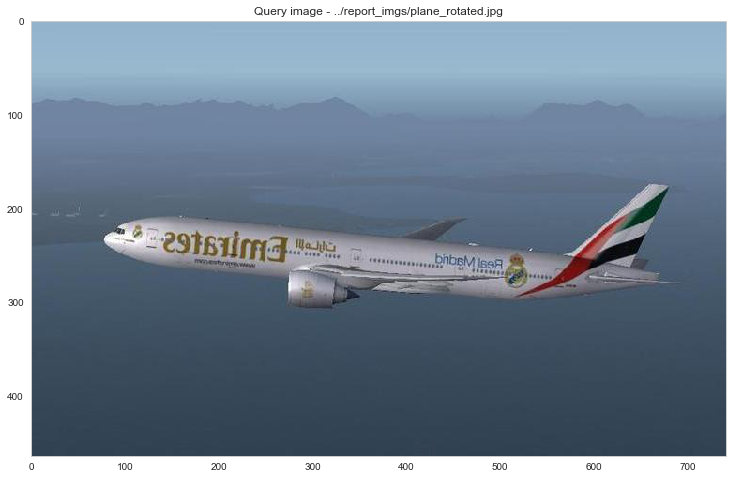

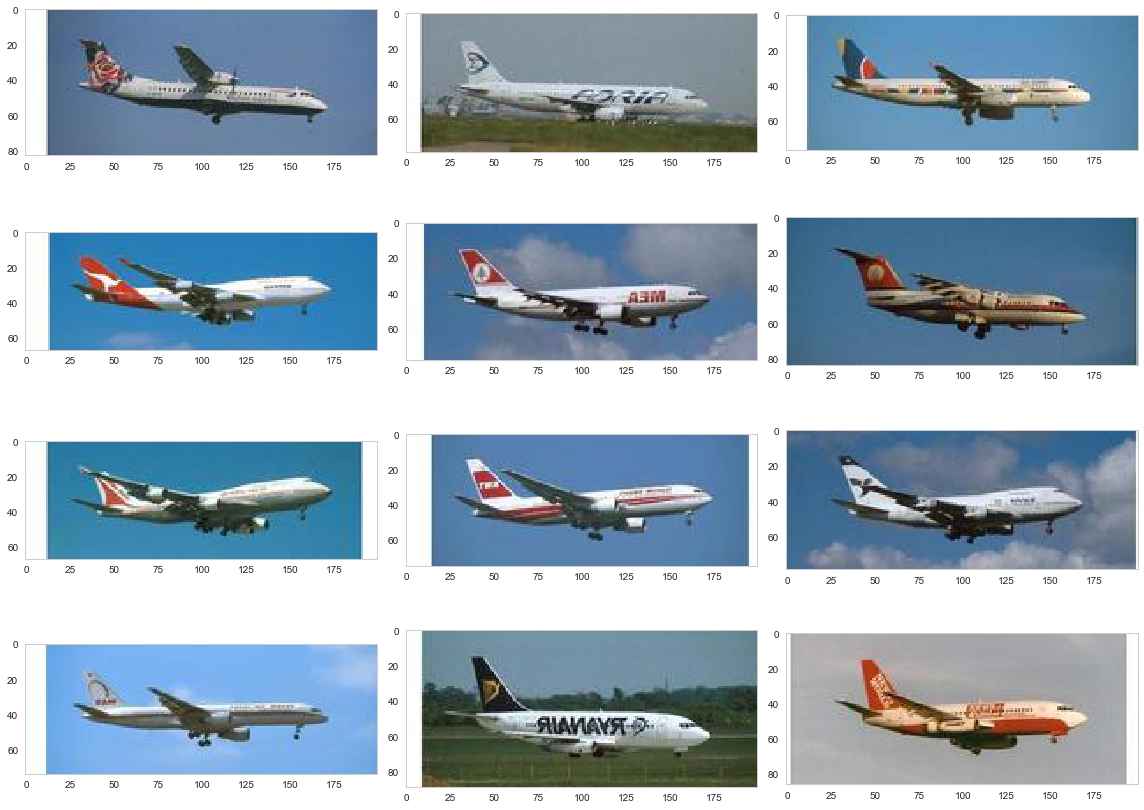

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


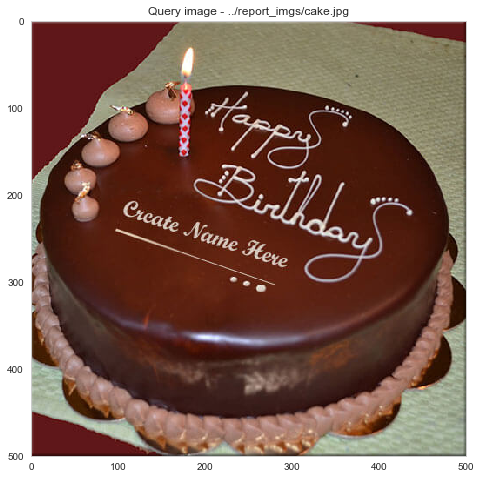

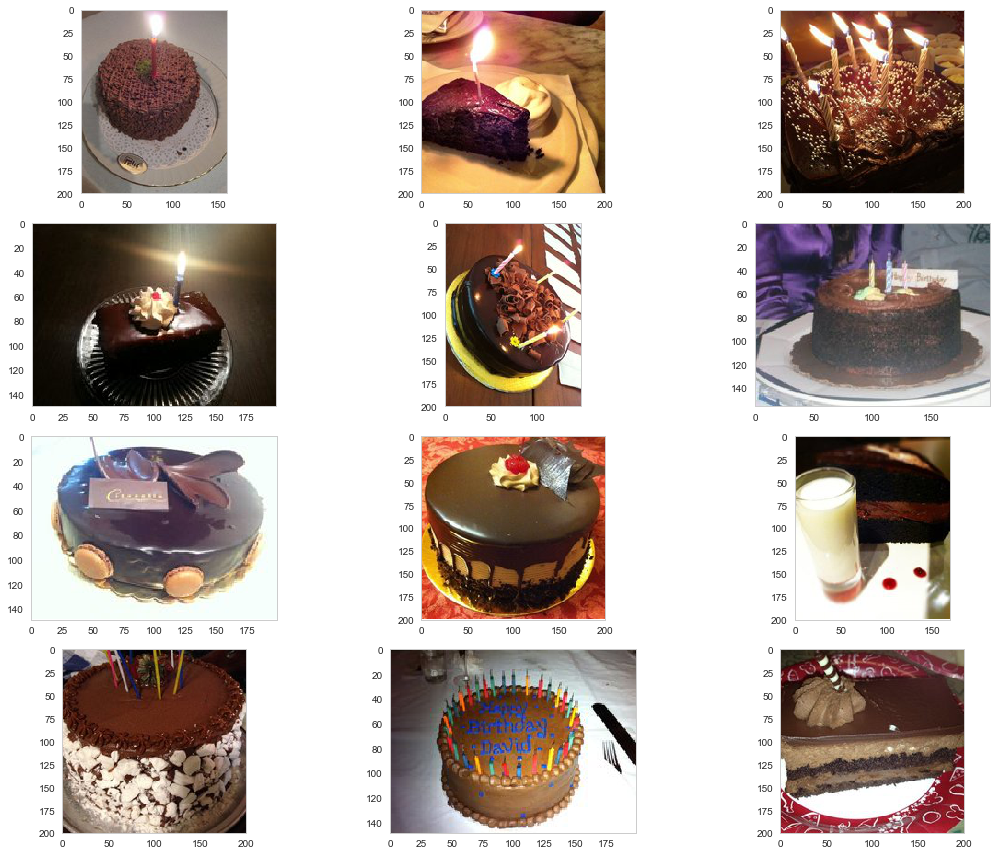

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


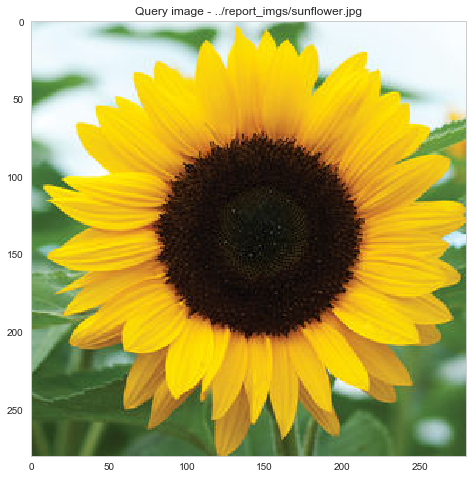

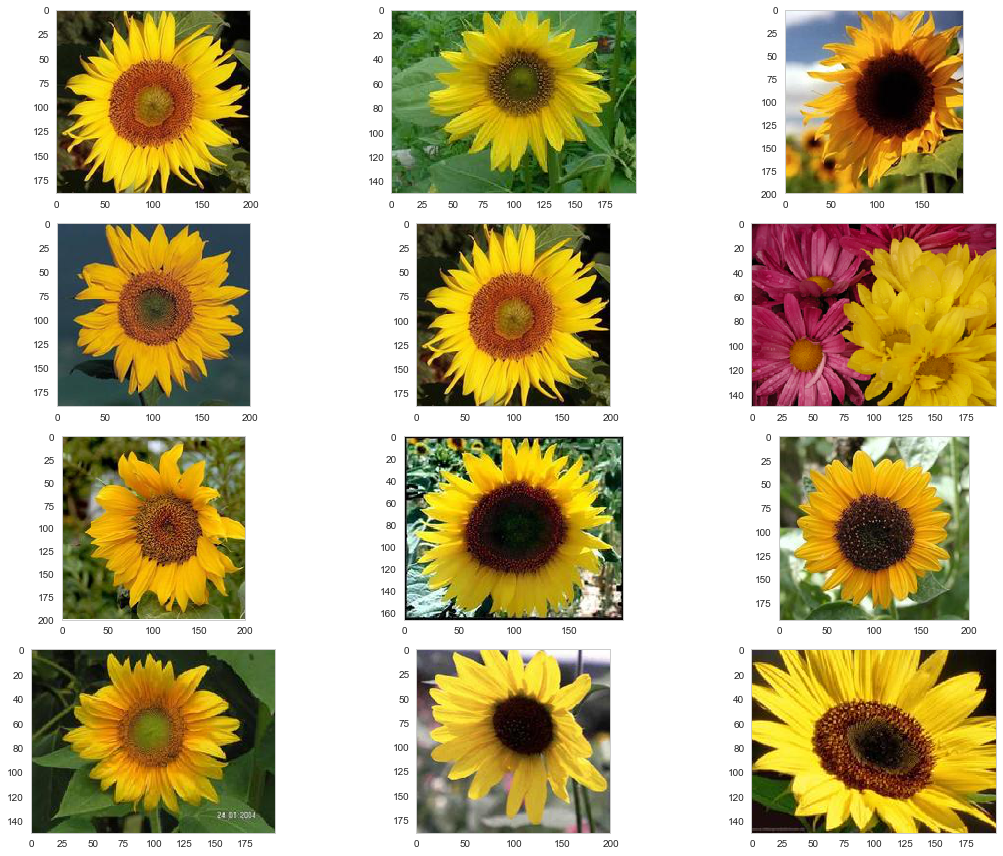

In [15]:
get_features = lambda x: features_extraction_model.extract_features([x])[0]

test_imgs = ['../report_imgs/plane_rotated.jpg', 
             '../report_imgs/cake.jpg', 
             '../report_imgs/sunflower.jpg']


for img in test_imgs:
    plot_closest_results(img, get_features, dataset)


# Clustering scores

# Clustering test

In [101]:
from sklearn.cluster.spectral import SpectralClustering
from sklearn.cluster import KMeans
from src.modules.clustering_scores import *
from sklearn.preprocessing import StandardScaler

Silhouette score
Number of cluster: 2
Scores: [[  2.00000000e+00   3.63675095e-02]
 [  3.00000000e+00   2.92870793e-02]
 [  4.00000000e+00   1.75292362e-02]
 [  5.00000000e+00   2.23000310e-02]
 [  6.00000000e+00   2.10165046e-02]
 [  7.00000000e+00   2.01365259e-02]
 [  8.00000000e+00   1.98198967e-02]
 [  9.00000000e+00   1.23111773e-02]
 [  1.00000000e+01   1.38538685e-02]
 [  1.10000000e+01   1.05188964e-02]
 [  1.20000000e+01   1.14236390e-02]
 [  1.30000000e+01   8.77719466e-03]
 [  1.40000000e+01   1.36014251e-02]
 [  1.50000000e+01   9.63674579e-03]]
time:155.33875942230225


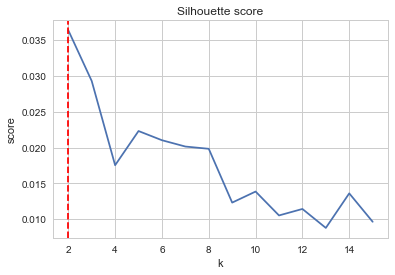

In [138]:
import time
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np


X = StandardScaler().fit_transform(dataset.features)
cluster_estimator = KMeans(n_jobs=-1)

for name, func_choose_nb_cluster in {
    'Silhouette score': max_silhouette
    #'Calinski-Harabasz score': max_CH_index,
    #'Stability': stability,
    #'Gap statistic': gap_statistic,
    #'Distortion jump': distortion_jump,
}.items():
    # predict cluster memberships
    t0 = time.time()
    nb_cluster, k_score = func_choose_nb_cluster(X, cluster_estimator, k_max=15)
    t1 = time.time()
    
    print("="*80)
    print(name)
    print("Number of cluster: %d" % nb_cluster)
    print("Scores: ", end='')
    print(k_score)
    print('time:', end='')
    print(t1-t0)
    
    plt.title(name)
    plt.xlabel("k")
    plt.ylabel("score")
    plt.plot(range(2,16), k_score[:,1])
    plt.axvline(nb_cluster, c='r', ls='--')
    plt.grid()
    plt.show()


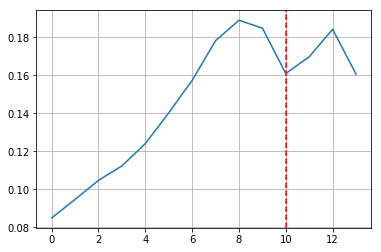

In [83]:
plt.plot(k_score[:,1])
plt.axvline(nb_cluster, c='r', ls='--')
plt.grid()

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [162]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=10)

x = dataset.features
clustering.fit(x)
dataset.save_clusters_to_file('./stl10_clusters', clustering.labels_, force_reload=True)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [163]:
# root dir for clusters ( dir/0/imgs, dir/1/imgs, ... ), labels need to be np.array 1D 
dataset.save_clusters_to_file('./stl10_clusters', clustering.labels_, force_reload=True)

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


In [112]:
import pickle
with open('../dataset/stl10/labels.pickle', 'rb') as f:
    labels_dict = pickle.load(f)

In [29]:
labels_dict

{'dog.9576.jpg': 1,
 'cat.2775.jpg': 0,
 'dog.1565.jpg': 1,
 'cat.9226.jpg': 0,
 'cat.11095.jpg': 0,
 'dog.7016.jpg': 1,
 'cat.4127.jpg': 0,
 'dog.1332.jpg': 1,
 'cat.6345.jpg': 0,
 'cat.312.jpg': 0,
 'cat.11321.jpg': 0,
 'cat.195.jpg': 0,
 'cat.10604.jpg': 0,
 'dog.4176.jpg': 1,
 'dog.7248.jpg': 1,
 'cat.11442.jpg': 0,
 'dog.1864.jpg': 1,
 'dog.88.jpg': 1,
 'dog.2996.jpg': 1,
 'dog.6253.jpg': 1,
 'cat.8194.jpg': 0,
 'cat.4206.jpg': 0,
 'dog.11097.jpg': 1,
 'cat.9542.jpg': 0,
 'cat.889.jpg': 0,
 'cat.4808.jpg': 0,
 'cat.6996.jpg': 0,
 'cat.8455.jpg': 0,
 'cat.1264.jpg': 0,
 'dog.4381.jpg': 1,
 'cat.2377.jpg': 0,
 'cat.3037.jpg': 0,
 'dog.227.jpg': 1,
 'dog.210.jpg': 1,
 'cat.11052.jpg': 0,
 'cat.4883.jpg': 0,
 'dog.10542.jpg': 1,
 'cat.7531.jpg': 0,
 'dog.11738.jpg': 1,
 'cat.8644.jpg': 0,
 'dog.2225.jpg': 1,
 'dog.6066.jpg': 1,
 'cat.838.jpg': 0,
 'cat.6527.jpg': 0,
 'cat.10665.jpg': 0,
 'cat.8576.jpg': 0,
 'dog.2705.jpg': 1,
 'dog.3517.jpg': 1,
 'cat.4815.jpg': 0,
 'cat.1999.jpg': 0,

In [120]:
labels_dict = {os.path.basename(p): l for p,l in labels_dict.items()}

## Evaluation on labeled datasets

In [ ]:
from itertools import combinations_with_replacement

def pca_summary(pca, standardised_data, out=True):
    names = [str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.Index(["sdev", "varproportion", "cumultiveproportion"])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    return summary

def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    x = x[:50]
    y = y[:50]
    
    print(x.shape, y.shape)
    plt.plot(x[:500], y[:500], "o-")
    plt.xticks(x[:500], ["Comp."+str(i) for i in x[:500]], rotation=60)
    plt.ylabel("Variance")
    plt.show()
    
def get_features(dir_path, features):
    lista = list(map(lambda x: dataset.path_to_id[os.path.basename(x)], glob.glob('%s/*'%dir_path)))
    return features[lista]    

def compute_metrics(root_path_of_clusters, features, metrics, verbose=True):
    # ako je ime slike 0001 tada se na indexu 0 u sorted_index nalazi index slike u dataset.paths i dataset.imgs
    clusters = sorted(glob.glob('%s/*' % root_path_of_clusters))
    diag = []
    upper_triang = []
    for d1,d2 in combinations_with_replacement(clusters, 2):
        out = metrics(get_features(d1, features), get_features(d2, features))
        if verbose:
            print("Cluster %s-%s" % (os.path.basename(d1), os.path.basename(d2)))
            print("\t min:  %f" % out.min())
            print("\t max:  %f" % out.max())
            print("\t mean: %f" % out.mean())
        if int(os.path.basename(d1)) == int(os.path.basename(d2)):
            diag.append(out.mean())
            
        elif int(os.path.basename(d1)) < int(os.path.basename(d2)):
            upper_triang.append(out.mean())
    diag_mean = np.array(diag).mean()
    upper_triag_mean = np.array(upper_triang).mean()
    if verbose:
        print("Mean of metrics within clusters:  %f"%diag_mean)
        print("Mean of metrics between clusters: %f"%upper_triag_mean)
    return diag_mean, upper_triag_mean    

def number_of_samples_in_group(root_path_of_clusters)

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.decomposition import PCA

for name in datasets.keys():
    n_samples = len(os.listdir(path))
    different_classes = get_n_different_classes(name)

results = []
model = AgglomerativeClustering # funkcija koja predstavlja model za grupirnaje
scaler = StandardScaler() # model za skaliranj, ako je None onda nema skaliranja
decomposition = PCA # model za dekompoziciju tj, funkcija za model
auto = True # automatsko odeivanje broja komponenti u PCA
similarity = cosine_similarity # metoda za izracun slicnosti

for name, path in dataset_imgs_root.items():
    n_samples = len(os.listdir(path))
    k = get_n_different_classes(name)

    if str(k) == 'unknown':
        # skip unlabeled datasets
        continue
    
    logging.info("Running %s", name)
    ds = ImageDataset(dataset_imgs_root[name])
    
    # get features
    features_path = pickled_features_path(name, features_extraction_model)
    if os.path.exists(features_path):
        # restore, skip loading in case of large dataset
        ds.load_features(features_path, skip_img_load=True)
    else:
        continue
        ds.extract_features(features_extraction_model)
        ds.store_features(features_path)

    
    if scaler is None:
        standardisedX = ds.features
    else:
        standardisedX = scaler.fit_transform(ds.features)
    pca = decomposition().fit(standardisedX)
    
    if auto:
        summary = pca_summary(pca, standardisedX)
        n_components = summary[summary.sdev**2 > 1].shape[0]
    else:
        plt.figure(figsize=(20,10))
        screeplot(pca, standardisedX)
        n_components = int(input("Unesite optimalan broj grupa(metoda lakta): "))
    
    transformedX = decomposition(n_components).fit_transform(standardisedX)
    print(n_components)
    
    clustering = model(n_clusters=k)
    clustering.fit(ds.features)
    
    # dump results to dir
    out_dir = os.path.join(CLUSTER_OUT_ROOT, '%s_%s' % (name, features_extraction_model.name))
    ds.save_clusters_to_file(out_dir, clustering.labels_, force_reload=True)
    
    model_name = str(clustering).split('(')[0]
    d,u = compute_metrics(out_dir, transformedX, similarity, False)
    
    print("="*80)
    print("Model: %s"%model_name)
    print("Feature extraction using %s"%features_extraction_model.name)
    print("Number of feature after decomposition %s"%n_components)
    print("Mean of metrics within clusters:  %f"%d)
    print("Mean of metrics between clusters: %f"%u)
    
    result.append(compare_cluster_to_labels(out_dir, name))

10
2017-05-19 10:57:18 INFO     Running cifar10


  0%|          | 0/10 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/marko/Projects/mozgalo2017/src/modules/../../dataset/cifar10/imgs/002696.jpg'

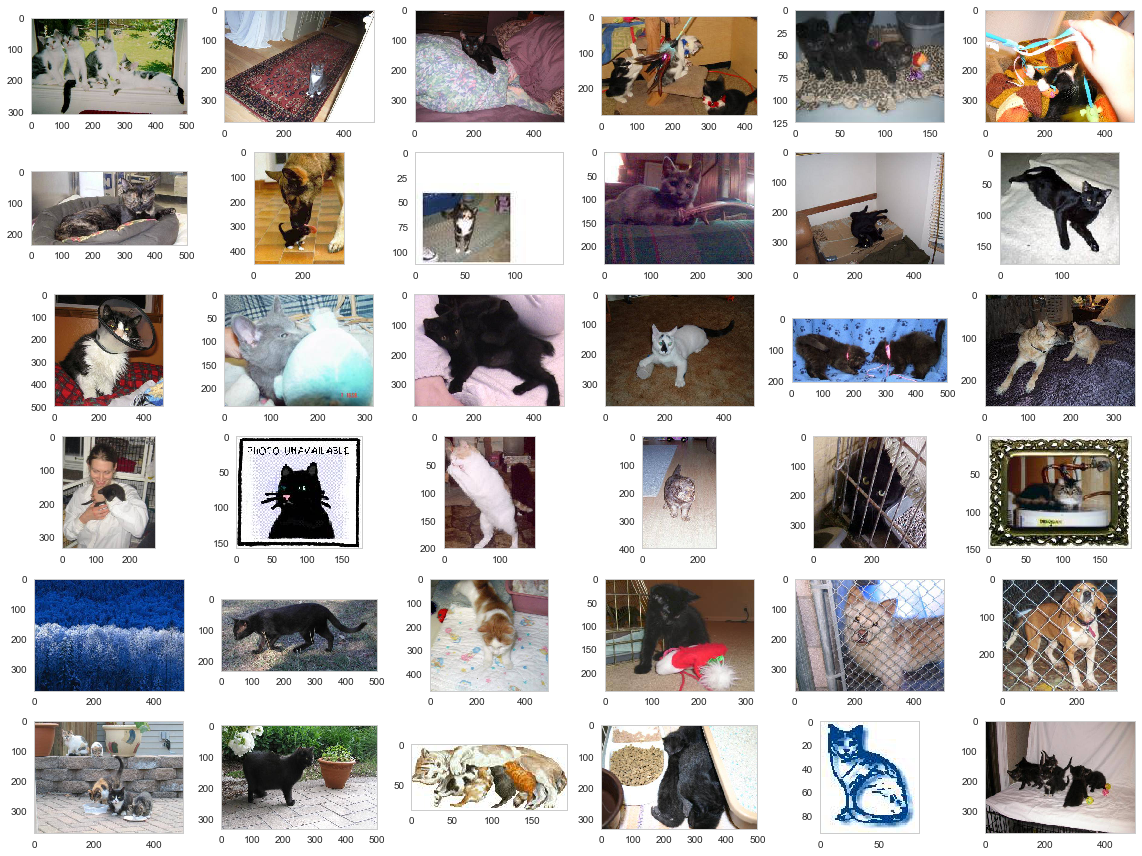

In [26]:
show_random_sample('./cats_dogs_clusters/_wrong/', 36)